## Compute Sagnac Frequency - Backscatter Correction

## Imports

In [4]:
import os
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read
from scipy.signal import hilbert


In [5]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

In [6]:
# from matplotlib import rc
# rc('text', usetex=True)

## Configurations

In [7]:
config = {}

config['ring'] = "U"

config['seed'] = "BW.DROMY..FJU"

config['path_to_sds'] = archive_path+"romy_archive/"

config['tbeg'] = UTCDateTime("2023-09-19 00:00")
config['tend'] = UTCDateTime("2023-09-19 10:00")

# config['f_lower_zoomin'], config['f_upper_zoomin'] = 448-10, 448+10

config['path_to_data'] = archive_path+f"romy_autodata/"

config['path_to_figs'] = data_path+"sagnac_frequency/figures/"

In [8]:
def __compute_psd(st0, twin_sec=60):

    from scipy.signal import welch, hann

    _st = st0.copy()

    _st.sort(keys=['channel'], reverse=True)

    nblock = int(st0[0].stats.sampling_rate * twin_sec)
    overlap = int(0.5*nblock)
    win = hann(nblock, True)

    Pxxs, ffs, chs = [], [], []

    for i, tr in enumerate(_st):

        ff, Pxx = welch(tr.data,
                        fs=tr.stats.sampling_rate,
                        window=win, noverlap=overlap,
                        nfft=nblock,
                        scaling="spectrum",
                        return_onesided=True)

        ffs.append(ff)
        chs.append(tr.stats.channel)
        Pxxs.append(Pxx)

    out = {}
    out['Pxxs'] = Pxxs
    out['ffs'] = ffs
    out['chs'] = chs

    return out

In [9]:
def __load_romy_raw_data(seeds, tbeg, tend, path_to_sds):

    from andbro__read_sds import __read_sds
    from obspy import Stream, UTCDateTime

    st0 = Stream()

    for seed in seeds:

        print(f" -> loading {seed}...")

        try:
            st00 = __read_sds(path_to_sds, seed, tbeg,tend, data_format='MSEED')
        except:
            print(f" -> failed for {seed}")

        st0 += st00

    st0 = st0.sort()

    for tr in st0:
        tr.data = tr.data*0.59604645e-6 # V / count  [0.59604645ug  from obsidian]

    return st0

## NEW ULLI

In [67]:
from andbro__read_sds import __read_sds

In [68]:
# st = __read_sds(config['path_to_sds'], config['seed'], config['tbeg'], config['tbeg']+1800)

In [69]:
sagn = read("/home/andbro/Downloads/mseed/30min/DROMY_FJU_2023-09-19.mseed").trim(config['tbeg'], config['tbeg']+60)
mon1 = read("/home/andbro/Downloads/mseed/30min/DROMY_F1V_2023-09-19.mseed").trim(config['tbeg'], config['tbeg']+60)
mon2 = read("/home/andbro/Downloads/mseed/30min/DROMY_F2V_2023-09-19.mseed").trim(config['tbeg'], config['tbeg']+60)

In [70]:
for tr in sagn:
    tr.data = tr.data*0.59604645e-6 # V / count  [0.59604645ug  from obsidian]
for tr in mon1:
    tr.data = tr.data*0.59604645e-6 # V / count  [0.59604645ug  from obsidian]
for tr in mon2:
    tr.data = tr.data*0.59604645e-6 # V / count  [0.59604645ug  from obsidian]


In [71]:
# sagn.plot();
# mon1.plot();
# mon2.plot();

## Processing

In [72]:
from functions.multitaper_psd import __multitaper_psd
from functions.welch_psd import __welch_psd
from acoustics.signal import phase_spectrum

In [73]:
# %load functions/welch_psd.py
def __welch_psd(arr, dt, twin_sec=60):

    from scipy.signal import welch
    from scipy.signal.windows import hann

    nblock = int(1/dt * twin_sec)
    overlap = int(0.5*nblock)
    win = hann(nblock, True)

    ff, Pxx = welch(arr,
                    fs=1/dt,
                    window=win, noverlap=overlap,
                    nfft=nblock,
                    scaling="density",
                    return_onesided=True)

    return ff, Pxx

In [74]:
def __get_values(ff, psd, fph, ph, f_sagn):

    from numpy import argmax, sqrt, where, argmin
    from acoustics.signal import phase_spectrum

    ## specify f-band around Sagnac frequency
    fl = f_sagn-2
    fu = f_sagn+2

    ## get index of Sagnac peak
    idx_fs = where(psd == max(psd[(ff > fl) & (ff < fu)]))[0][0]

    ## estimate Sagnac frequency
    f_sagn_est = ff[idx_fs]

    ## estimate AC value at Sagnac peak
    # AC_est = max(psd[(ff > fl) & (ff < fu)])
    AC_est = psd[idx_fs]

    ## estimate DC value at ff = 0
    DC_est = psd[0]

    ## estimate phase at Sagnac peak
    idx_ph = argmin(abs(fph- f_sagn_est)) ## finde index of phase closest to sagnac frequency
    phase_est = ph[idx_ph] ## select phase of Sagnac

    return f_sagn_est, sqrt(AC_est), sqrt(DC_est), phase_est

In [75]:
f_m, psd_m = __multitaper_psd(mon1[0].data, mon1[0].stats.delta, n_win=4)

DPSS using interpolation 300001 100000


In [76]:
f_w, psd_w = __welch_psd(mon1[0].data, mon1[0].stats.delta, twin_sec=60)

In [77]:
f_pha, pha = phase_spectrum(mon1[0].data, mon1[0].stats.sampling_rate)

In [78]:
fs_w, ac_w, dc_w, ph_w = __get_values(f_w, psd_w, f_pha, pha, 303)

In [79]:
fs_m, ac_m, dc_m, ph_m = __get_values(f_m, psd_m, f_pha, pha, 303)

In [80]:
f_pha1, pha1 = phase_spectrum(mon1[0].data, mon1[0].stats.sampling_rate)
f_pha2, pha2 = phase_spectrum(mon2[0].data, mon2[0].stats.sampling_rate)
f_pha, pha = phase_spectrum(sagn[0].data, sagn[0].stats.sampling_rate)

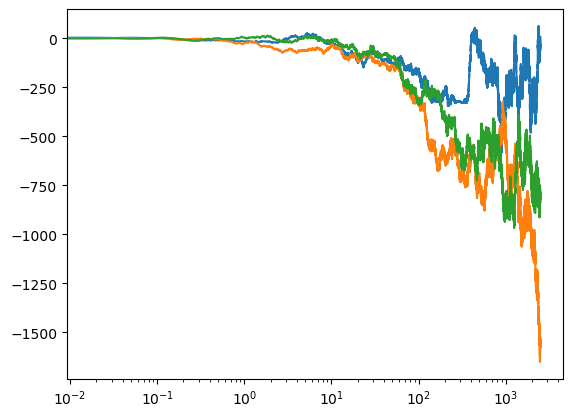

In [81]:
plt.semilogx(f_pha, pha)
plt.semilogx(f_pha1, pha1)
plt.semilogx(f_pha2, pha2)

## Plotting

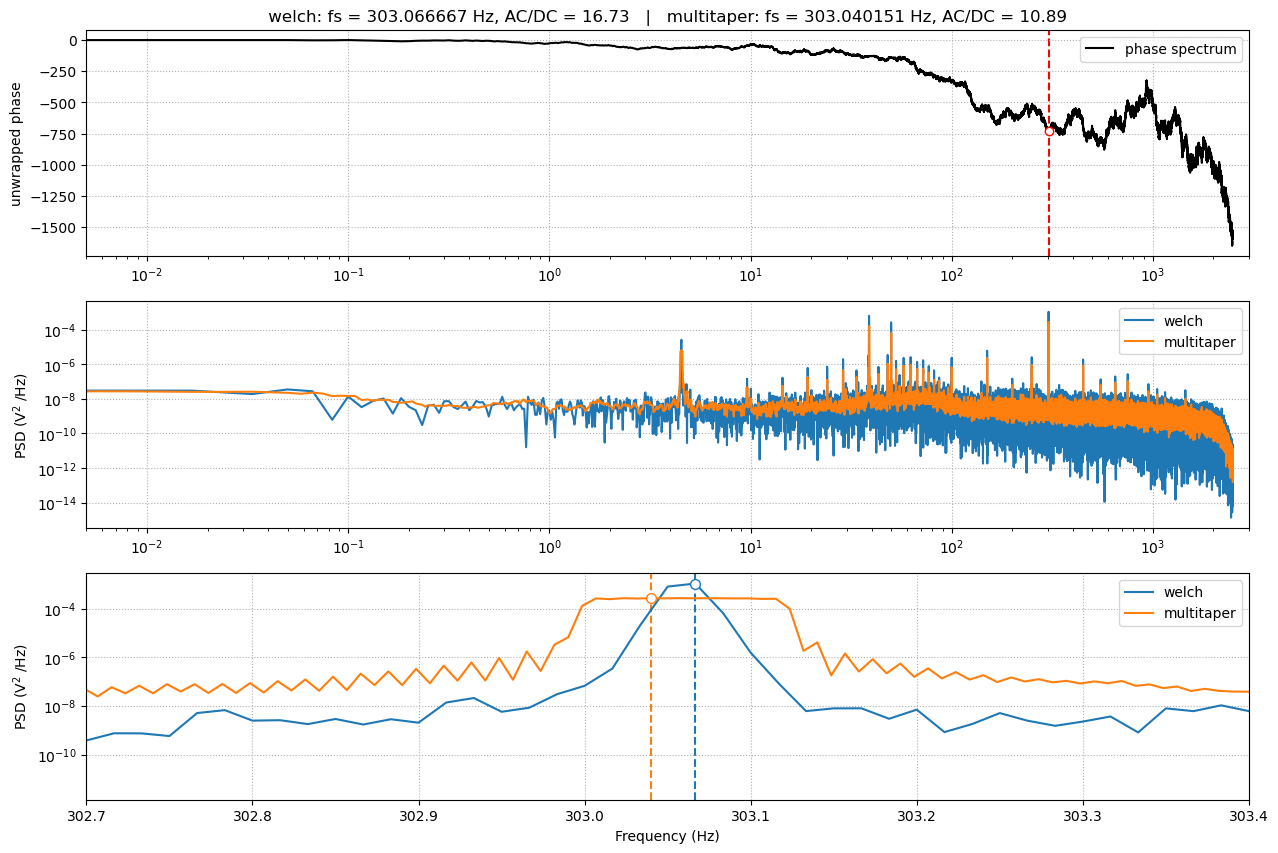

In [82]:
def __makeplot():

    Nrow = 3

    fig, ax = plt.subplots(Nrow, 1, figsize=(15, 10))

    ax[0].semilogx(f_pha1, pha1, color="k", label="phase spectrum")
    ax[0].scatter(fs_w, ph_w, color="w", edgecolor="r", zorder=2)
    ax[0].axvline(fs_w,  color="r", ls="--", zorder=1)


    ax[1].loglog(f_w, psd_w, label="welch")
    ax[1].loglog(f_m, psd_m, label="multitaper")

    ax[2].semilogy(f_w[(f_w > 300) & (f_w < 304)], psd_w[(f_w > 300) & (f_w < 304)], label="welch")
    ax[2].semilogy(f_m[(f_m > 300) & (f_m < 304)], psd_m[(f_m > 300) & (f_m < 304)], label="multitaper")

    ax[2].scatter(fs_w, ac_w**2, s=50, color="white", edgecolors="tab:blue", zorder=2)
    ax[2].scatter(fs_m, ac_m**2, s=50, color="white", edgecolor="tab:orange", zorder=2)

    ax[2].axvline(fs_w,  color="tab:blue", ls="--", zorder=1)
    ax[2].axvline(fs_m, color="tab:orange", ls="--", zorder=1)

    for i in range(Nrow):
        ax[i].grid(ls=":", zorder=0)
        ax[i].legend(loc=1)

    ax[2].set_xlim(302.7, 303.4)

    ax[0].set_xlim(5e-3, 3e3)
    ax[1].set_xlim(5e-3, 3e3)

    # ax[1].set_xlabel("Frequency (Hz)")
    ax[2].set_xlabel("Frequency (Hz)")

    ax[0].set_ylabel("unwrapped phase")
    ax[1].set_ylabel("PSD (V$^2$ /Hz)")
    ax[2].set_ylabel("PSD (V$^2$ /Hz)")

    ac_dc_w = np.sqrt( ac_w / dc_w )
    ac_dc_m = np.sqrt( ac_m / dc_m )

    title_m = f"multitaper: fs = {round(fs_m,6)} Hz, AC/DC = {round(ac_dc_m,2)}"
    title_w = f"welch: fs = {round(fs_w,6)} Hz, AC/DC = {round(ac_dc_w,2)}"
    ax[0].set_title(f" {title_w}   |   {title_m} ")

    plt.show();
    return fig

fig = __makeplot()

# fig.savefig(config['path_to_figs']+f"SagnacFrequency_BS_compare_welch_multitaper.jpeg", format="jpeg", dpi=200, bbox_inches='tight')

## Automatic

In [108]:
sagn = read("/home/andbro/Downloads/mseed/DROMY_FJU_2023-09-19.mseed").trim(config['tbeg'], config['tend'])
mon1 = read("/home/andbro/Downloads/mseed/DROMY_F1V_2023-09-19.mseed").trim(config['tbeg'], config['tend'])
mon2 = read("/home/andbro/Downloads/mseed/DROMY_F2V_2023-09-19.mseed").trim(config['tbeg'], config['tend'])

In [109]:
for tr in sagn:
    tr.data = tr.data*0.59604645e-6 # V / count  [0.59604645ug  from obsidian]
for tr in mon1:
    tr.data = tr.data*0.59604645e-6 # V / count  [0.59604645ug  from obsidian]
for tr in mon2:
    tr.data = tr.data*0.59604645e-6 # V / count  [0.59604645ug  from obsidian]


In [110]:
from functions.get_time_intervals import __get_time_intervals

In [111]:
tbeg, tend = sagn[0].stats.starttime, sagn[0].stats.endtime

interval = 60 ## seconds

times = __get_time_intervals(tbeg, tend, interval_seconds=interval, interval_overlap=0)

In [87]:
# fs_w, ac_w, dc_w, ph = np.ones(len(times))*np.nan, np.ones(len(times))*np.nan, np.ones(len(times))*np.nan, np.ones(len(times))*np.nan
# fs_m, ac_m, dc_m, ph = np.ones(len(times))*np.nan, np.ones(len(times))*np.nan, np.ones(len(times))*np.nan, np.ones(len(times))*np.nan

# for _n, (t1, t2) in enumerate(times):

#     _dat = sagn.copy().trim(t1, t2)

#     f_w, psd_w = __welch_psd(_dat[0].data, _dat[0].stats.delta, twin_sec=60)
#     f_m, psd_m = __multitaper_psd(_dat[0].data, _dat[0].stats.delta, n_win=4)
#     f_pha, pha = phase_spectrum(mon1[0].data, mon1[0].stats.sampling_rate)

#     fs_w[_n], ac_w[_n], dc_w[_n], ph[_n] = __get_values(f_w, psd_w, f_pha, pha, 303)
#     fs_m[_n], ac_m[_n], dc_m[_n], ph[_n] = __get_values(f_m, psd_m, f_pha, pha, 303)



In [ ]:
def __makeplot():

    Nrow, Ncol = 5, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8))

    ax[0].scatter(np.array(range(len(fs_w)))+0.5, fs_w, zorder=2)
    ax[0].scatter(np.array(range(len(fs_m)))+0.5, fs_m, zorder=2)

    ax[1].scatter(np.array(range(len(ac_w)))+0.5, ac_w, zorder=2)
    ax[1].scatter(np.array(range(len(ac_m)))+0.5, ac_m, zorder=2)

    ax[2].scatter(np.array(range(len(dc_w)))+0.5, dc_w, zorder=2)
    ax[2].scatter(np.array(range(len(dc_m)))+0.5, dc_m, zorder=2)

    ax[3].scatter(np.array(range(len(dc_w)))+0.5, ac_w/dc_w, zorder=2)
    ax[3].scatter(np.array(range(len(dc_m)))+0.5, ac_m/dc_m, zorder=2)

    ax[3].set_yscale("log")

    ax[4].scatter(np.array(range(len(ph)))+0.5, ph, zorder=2)


    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)

    plt.show();
    return fig

__makeplot();

In [ ]:
fs, ac, dc, ph = np.ones(len(times))*np.nan, np.ones(len(times))*np.nan, np.ones(len(times))*np.nan, np.ones(len(times))*np.nan
# f1_fs, f1_ac, f1_dc, f1_ph = np.ones(len(times))*np.nan, np.ones(len(times))*np.nan, np.ones(len(times))*np.nan, np.ones(len(times))*np.nan
# f2_fs, f2_ac, f2_dc, f2_ph = np.ones(len(times))*np.nan, np.ones(len(times))*np.nan, np.ones(len(times))*np.nan, np.ones(len(times))*np.nan


out_df = DataFrame()
out_df['time1'] = list(zip(*times))[0]
out_df['time2'] = list(zip(*times))[1]

for _k, _st in enumerate([sagn, mon1, mon2]):

    for _n, (t1, t2) in enumerate(times):

        _dat = _st.copy().trim(t1, t2)

        # f, psd = __welch_psd(_dat[0].data, _dat[0].stats.delta, twin_sec=interval)
        f, psd = __multitaper_psd(_dat[0].data, _dat[0].stats.delta, n_win=4)

        f_pha, pha = phase_spectrum(_dat[0].data, _dat[0].stats.sampling_rate)

        fs[_n], ac[_n], dc[_n], ph[_n] = __get_values(f, psd, f_pha, pha, 303)

    if _k == 0:
        out_df['fj_fs'], out_df['fj_ac'], out_df['fj_dc'], out_df['fj_ph'] = fs, ac, dc, ph
    elif _k == 1:
        out_df['f1_fs'], out_df['f1_ac'], out_df['f1_dc'], out_df['f1_ph'] = fs, ac, dc, ph
    elif _k == 2:
        out_df['f2_fs'], out_df['f2_ac'], out_df['f2_dc'], out_df['f2_ph'] = fs, ac, dc, ph


DPSS using interpolation 300001 100000
DPSS using interpolation 300001 100000
DPSS using interpolation 300001 100000
DPSS using interpolation 300001 100000
DPSS using interpolation 300001 100000
DPSS using interpolation 300001 100000
DPSS using interpolation 300001 100000
DPSS using interpolation 300001 100000
DPSS using interpolation 300001 100000
DPSS using interpolation 300001 100000
DPSS using interpolation 300001 100000
DPSS using interpolation 300001 100000
DPSS using interpolation 300001 100000
DPSS using interpolation 300001 100000
DPSS using interpolation 300001 100000
DPSS using interpolation 300001 100000
DPSS using interpolation 300001 100000
DPSS using interpolation 300001 100000
DPSS using interpolation 300001 100000
DPSS using interpolation 300001 100000
DPSS using interpolation 300001 100000
DPSS using interpolation 300001 100000
DPSS using interpolation 300001 100000
DPSS using interpolation 300001 100000
DPSS using interpolation 300001 100000
DPSS using interpolation 

In [ ]:
out_df

In [ ]:
def __makeplot(df):

    Nrow, Ncol = 5, 1

    font = 12
    ms = 15

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 10), sharex=True)

    t_axis = (np.array(range(len(df['fj_fs'])))+0.5)*interval/60

    ax[0].scatter(t_axis, df['fj_fs'], zorder=2, s=ms, label="fj")
    ax[0].scatter(t_axis, df['f1_fs'], zorder=2, s=ms, label="f1")
    ax[0].scatter(t_axis, df['f2_fs'], zorder=2, s=ms, label="f2")
    ax[0].set_ylabel("$\delta$f (Hz)")
    ax[0].ticklabel_format(useOffset=False)

    ax[1].scatter(t_axis, df['fj_ac'], zorder=2, s=ms, label="fj")
    ax[1].scatter(t_axis, df['f1_ac'], zorder=2, s=ms, label="f1")
    ax[1].scatter(t_axis, df['f2_ac'], zorder=2, s=ms, label="f2")
    ax[1].set_ylabel("AC (V / $\sqrt{Hz})$")

    ax[2].scatter(t_axis, df['fj_dc'], zorder=2, s=ms, label="fj")
    ax[2].scatter(t_axis, df['f1_dc'], zorder=2, s=ms, label="f1")
    ax[2].scatter(t_axis, df['f2_dc'], zorder=2, s=ms, label="f2")
    ax[2].set_ylabel("DC (V / $\sqrt{Hz})$")

    ax[3].scatter(t_axis, df['fj_ac']/df['fj_dc'], zorder=2, s=ms, label="fj")
    ax[3].scatter(t_axis, df['f1_ac']/df['f1_dc'], zorder=2, s=ms, label="f1")
    ax[3].scatter(t_axis, df['f2_ac']/df['f2_dc'], zorder=2, s=ms, label="f2")
    ax[3].set_yscale("log")
    ax[3].set_ylabel("AC/DC")

    ax[4].scatter(t_axis, df['f1_ph']/df['f2_ph'], color="k", zorder=2, s=ms, label="f1-f2")
    ax[4].set_ylabel("$\Delta$ Phase")

    ax[4].set_xlabel("Time (min)")

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1, ncol=3)

    plt.show();
    return fig

fig = __makeplot(out_df);

# fig.savefig(config['path_to_figs']+f"SagnacFrequency_BS_welch_values.jpeg", format="jpeg", dpi=200, bbox_inches='tight')

## Define quantities

In [ ]:
# fractional beat modulations
m01 = out_df.f1_ac / out_df.f1_dc
m02 = out_df.f2_ac / out_df.f2_dc


# phase difference
# phase0 = abs(hilbert(beat.f1 - beat.f2))
phase0 = out_df.f1_ph - out_df.f2_ph

# beat signal observered
w_obs = out_df.fj_fs


## from Hurst 2014

## free spectral range fsr = c / P
fL = 8e6 ## Hz

## gain
alpha = 7.39e-6

## sekf-saturation coefficient
beta = 4.67e-5

## cross-saturation coefficient
theta = 1.014e-5

# I0 = 

## Correct for bias

In [ ]:
m1 = m01 * ( 1 + m01**2 / 4 )
m2 = m02 * ( 1 + m02**2 / 4 )

## Angular correction for phase

In [ ]:
phase = phase0 + 0.5 * m1 * m2 * np.sin( phase0 )

## Compute squares of the common-mode and differential-mode modulations

In [ ]:
m2c = ( m1**2 + m2**2 + 2*m1*m2*np.cos( phase ) ) / 4
m2d = ( m1**2 + m2**2 - 2*m1*m2*np.cos( phase ) ) / 4  ## different angle!

## Correct m2c for gain saturation for a He-Ne laser

In [ ]:
# m2c = m2c * ( 1 + ( beta + theta )**2 * fL**2 * I0**2 / ws**2 )

## Compute M as BS correction

In [ ]:
M = m2c - m2d + 0.25 * m1**2 * m2**2 * np.sin(phase)**2

In [ ]:
plt.plot(M)

## Beat Correction

In [ ]:
w_s = w_obs * ( 4 + M ) / ( 4 - M )

## Plotting

In [ ]:
def __makeplot():

    Nrow, Ncol = 5, 1

    font = 12
    ms = 15

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 10), sharex=True)

    t_axis = beat.times_utc_sec/3600

    ax[0].plot(t_axis, w_obs, color="k", label="$\omega_{obs}$")
    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel("$\delta$f$_{obs}$ (Hz)")

    ax[1].plot(t_axis, m01, label="m01")
    ax[1].plot(t_axis, m02, label="m02")
    ax[1].set_ylabel("fractional modulation")

    ax[2].plot(t_axis, phase, color="k", label="m01-m02")
    ax[2].set_ylabel("phase")

    ax[3].plot(t_axis, M, color="k", label="M")
    ax[3].set_ylabel("BS Correction")

    ax[4].plot(t_axis, w_s, color="k", label="$\omega_{s}$")
    ax[4].set_ylabel("$\delta$f$_{corrected}$ (Hz)")

    ax[4].set_xlabel("Time (hour)")

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1, ncol=3)

    plt.show();
    return fig

fig = __makeplot();

# fig.savefig(config['path_to_figs']+f"SagnacFrequency_BS_frequencyomain.png", format="png", dpi=200, bbox_inches='tight')